# MARKOV CHAIN MONTE CARLO (MCMC)

First, go through this very elaborative tutorial (https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html) to understand what MCMC reallt is.
Once done, we will now do the following. If you've gone through the tutorial 2, you already know what a lightcurve is. There, we used conventional scipy fit to fit the curve but today we will use MCMC to find the best parameters for fitting the curve.

Light curves are graphical representations of the variation in brightness or flux of an astronomical object over time. Fitting light curves with models allows us to extract valuable information about the physical processes governing these sources. The smooth broken power-law model is one such model used to describe the flux evolution.
Light curves are graphical representations of the variation in brightness or flux of an astronomical object over time. Fitting light curves with models allows us to extract valuable information about the physical processes governing these sources. The smooth broken power-law model is one such model used to describe the flux evolution.\\

The smooth broken power-law model is parametrized as follows:\\

$$[ F(t, \nu) = \frac{2}{1} \left( \frac{\nu}{3 \, \text{GHz}} \right)^{\beta} \frac{F_p}{{(t/t_p)}^s} \left[ \left( \frac{t}{t_p} \right)^{-s\alpha_1} + \left( \frac{t}{t_p} \right)^{-s\alpha_2} \right]^{-\frac{1}{s}} ]$$


where:\\
\( F(t, $\nu$)) is the flux density at time ( t ) and observing frequency ( $\nu$ ). 


$( \beta$) is the spectral index. 


$( F_p$) is the flux density at 3 GHz at the light curve peak time $( t_p $). 


$(t$) is the time post-merger.


$( t_p $) is the light curve peak time.


$( s $) is the smoothness parameter.


$( \alpha_1 $) and $( \alpha_2 $) are the power-law rise and decay slopes, respectively.



In [1]:
import numpy as np
from astropy.io import ascii
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import emcee
import corner
%matplotlib inline

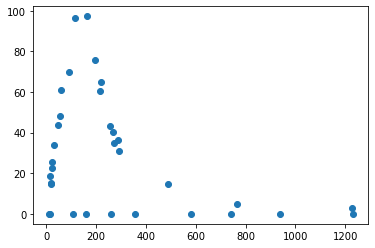

         DateUT            T    Telescope     Freq     FluxD  FluxDErr
------------------------ ------ --------- ------------ ------ --------
            2017-Sep-2.9   16.4       VLA 3000000000.0 1.87e1      6.3
            2017-Sep-3.9   17.4       VLA 3000000000.0 1.51e1      3.9
            2017-Sep-4.9   18.3       VLA 3000000000.0 1.45e1      3.7
            2017-Sep-8.9   22.4       VLA 3000000000.0 2.25e1      3.4
           2017-Sep-10.8   24.2       VLA 3000000000.0 2.56e1      2.9
           2017-Sep-17.8   31.3       VLA 3000000000.0 3.40e1      3.6
            2017-Oct-2.8   46.3       VLA 3000000000.0 4.40e1      4.0
                     ...    ...       ...          ...    ...      ...
             2018-May-12  267.0       VLA 3000000000.0 4.03e1      2.7
             2018-May-17  273.0       VLA 3000000000.0 3.48e1      4.9
              2018-Jun-2  289.0       VLA 3000000000.0 3.63e1      3.9
              2018-Jun-7  294.0       VLA 3000000000.0 3.12e1      3.6
      

In [17]:
# Read data from the file 'gw170817_afterglow_data_full.txt' using the 'ascii.read' function
gw170817 = ascii.read('gw170817_afterglow_data_full.txt')

# Filter the data for observations made with the VLA (Very Large Array) telescope at a frequency of 3.00 GHz
VLA_gw170817 = gw170817[(gw170817['Telescope'] == 'VLA') & (gw170817['Freq'] == 3.00e9)]

# Filter the data for observations made with the Chandra X-ray telescope
CH_gw170817 = gw170817[(gw170817['Telescope'] == 'Chandra')]

# Define a function 'safe_float' to convert a value to a float, handling ValueError exceptions
def safe_float(value):
    try:
        return float(value)
    except ValueError:
        return None

# Apply the 'safe_float' function to filter out rows with non-convertible 'FluxD' values in the VLA data
VLA_gw170817 = VLA_gw170817[[safe_float(x) is not None for x in VLA_gw170817['FluxD']]]

# Convert relevant columns in the VLA data to arrays of appropriate data types
FluxD_VLA = VLA_gw170817['FluxD'].astype(float)
Time_VLA = VLA_gw170817['T'].astype(float)
Freq_VLA = VLA_gw170817['Freq'].astype(float)
FluxDErr_VLA = VLA_gw170817['FluxDErr'].astype(float)

# Apply the 'safe_float' function to filter out rows with non-convertible 'FluxD' values in the Chandra data
CH_gw170817 = CH_gw170817[[safe_float(x) is not None for x in CH_gw170817['FluxD']]]

# Convert relevant columns in the Chandra data to arrays of appropriate data types
FluxD_CH = np.array(CH_gw170817['FluxD']).astype(float)
Time_CH = np.array(CH_gw170817['T']).astype(float)
Freq_CH = np.array(CH_gw170817['Freq']).astype(float)
FluxDErr_CH = np.array(CH_gw170817['FluxDErr']).astype(float)

# Concatenate the VLA and Chandra data arrays to create combined arrays for plotting
FluxD = np.concatenate((FluxD_VLA, FluxD_CH))
Time = np.concatenate((Time_VLA, Time_CH))
Freq = np.concatenate((Freq_VLA, Freq_CH))
FluxDErr = np.concatenate((FluxDErr_VLA, FluxDErr_CH))

# Plotting the data using a scatter plot
plt.scatter(Time, FluxD)
plt.show()

# Print the filtered VLA data
print(VLA_gw170817)

In [18]:
# Functions for MCMC

# Define the function 'smoothBrokenPowerLaw' that represents the smooth broken power law model
# This function takes parameters 'params', observing time 't', and observing frequency 'v'
def smoothBrokenPowerLaw(params, t, v):
    """
    v : observing frequency
    b : spectral index
    s : smoothness parameter
    Fp : peak flux
    tp : peak time
    a1 : power-law rise
    a2 : power-law decay
    """
    s, Fp, tp, a1, a2, b = params
    return (2**(1/10**s)) * ((v/3e9)**b) * Fp * ( (t/tp)**(-10**s*a1) + (t/tp)**(-10**s*a2) )**(-1/10**s)

# Define a function 'MCMC' for running an MCMC (Markov Chain Monte Carlo) analysis
# This function takes flux, time, error, and frequency data as inputs
def MCMC(setFlux, setTime, setErr, setFreq):

    # Define the log likelihood function 'lnlike'
    def lnlike(params, x, y, yerr):
        return -0.5 * np.sum(((y - smoothBrokenPowerLaw(params, x, setFreq))/yerr) ** 2)

    # Define the log prior function 'lnprior'
    def lnprior(params):
        s, Fp, tp, a1, a2, b = params
        if 0 < s < 1.5 and 90 < Fp < 120 and 100 < tp < 200 and 0 < a1 < 1 and -2 < a2 < -1 and -1 < b < 0:
            return 0.0
        return -np.inf

    # Define the log probability function 'lnprob'
    def lnprob(params, x, y, yerr):
        lp = lnprior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnlike(params, x, y, yerr)

    # Organize the data for MCMC analysis
    Data = (setTime, setFlux, setErr)
    nwalkers = 248
    niter = 1000
    initial = np.array([0.56, 100, 155, 0.86, -1.92, -0.58])  # s, Fp, tp, a1, a2, b
    ndim = len(initial)
    p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

    # Define the main function for running the MCMC analysis
    def main(p0, nwalkers, niter, ndim, lnprob, data):
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)  # Assuming 'emcee' library is imported

        print("Running burn-in...")
        p0, _, _ = sampler.run_mcmc(p0, 100)
        sampler.reset()

        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter)

        return sampler, pos, prob, state

    # Call the main function and return relevant outputs
    sampler, pos, prob, state = main(p0, nwalkers, niter, ndim, lnprob, Data)
    return sampler, pos, prob, state


In [19]:
# Run the MCMC analysis using the 'MCMC' function to fit the model to the data
# This assumes that 'FluxD', 'Time', 'FluxDErr', and 'Freq' are defined and contain the appropriate data
samplerCH, posCH, probCH, stateCH = MCMC(FluxD, Time, FluxDErr, Freq)

# Extract the chain samples from the MCMC sampler for further analysis
samplesCH = samplerCH.flatchain


Running burn-in...
Running production...


In the above section of code, the MCMC function is called to perform an MCMC analysis on the provided data (FluxD, Time, FluxDErr, Freq) using the model defined earlier. The results of the MCMC analysis are stored in samplerCH, posCH, probCH, and stateCH, which represent the sampler, positions, probabilities, and state of the MCMC run, respectively. The flatchain attribute of the sampler (samplerCH.flatchain) is used to extract the chain samples, which can be useful for further analysis, such as estimating parameter uncertainties, correlations, and confidence intervals.

In [20]:
# Find the parameter values corresponding to the maximum log probability in the MCMC samples
theta_max = samplesCH[np.argmax(samplerCH.flatlnprobability)]

# Calculate the best-fit model using the extracted parameter values and the 'smoothBrokenPowerLaw' function
best_fit_model = smoothBrokenPowerLaw(theta_max, Time, Freq)

# Print the parameter values that correspond to the best-fit model
print(theta_max)

[  0.62943851  96.09523184 156.05223846   0.80013513  -1.8163655
  -0.58151099]


In the above section of code, the MCMC samples obtained from the sampler (samplesCH) are analyzed to find the parameter values (theta_max) that correspond to the maximum log probability. This point in parameter space represents the best-fit model according to the MCMC analysis. The smoothBrokenPowerLaw function is then used with the best-fit parameters to generate the best-fit model. Finally, the parameter values of the best-fit model are printed using print(theta_max). This can be useful to understand the parameter values that provide the best agreement between the model and the data.

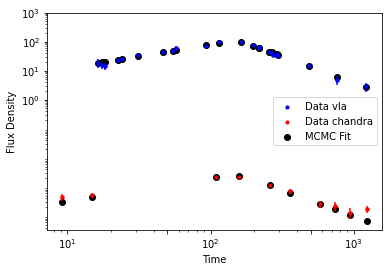

Chandra:  [  0.62943851  96.09523184 156.05223846   0.80013513  -1.8163655
  -0.58151099]
VLA:  [  0.62943851  96.09523184 156.05223846   0.80013513  -1.8163655
  -0.58151099]


In [21]:
# Find the parameter values corresponding to the maximum log probability in the MCMC samples
theta_max = samplesCH[np.argmax(samplerCH.flatlnprobability)]

# Calculate the best-fit model using the extracted parameter values and the 'smoothBrokenPowerLaw' function
best_fit_model = smoothBrokenPowerLaw(theta_max, Time, Freq)

# Plot the data, MCMC fit, and error bars
plt.scatter(Time_VLA, FluxD_VLA, label='Data vla', color='b', s=10)
plt.errorbar(Time_VLA, FluxD_VLA, yerr=FluxDErr_VLA, fmt='.', color='b')
plt.scatter(Time_CH, FluxD_CH, label='Data chandra', color='r', s=10)
plt.errorbar(Time_CH, FluxD_CH, yerr=FluxDErr_CH, fmt='.', color='r')
plt.scatter(Time, best_fit_model, label='MCMC Fit', color='black')

# Add labels and adjust plot settings
plt.ylabel('Flux Density')
plt.xlabel('Time')

# Define y-axis and x-axis tick values for log scale
yticks = [1, 10, 100, 1000]
plt.yscale('log')
plt.yticks(yticks)

xticks = [10, 50, 100, 500, 1000]
plt.xscale('log')
plt.xticks(xticks)

# Add a legend to the plot
plt.legend()

# Display the plot
plt.show()

# Print the best-fit parameter values for Chandra and VLA data
print('Chandra: ', theta_max)
print('VLA: ', theta_max)


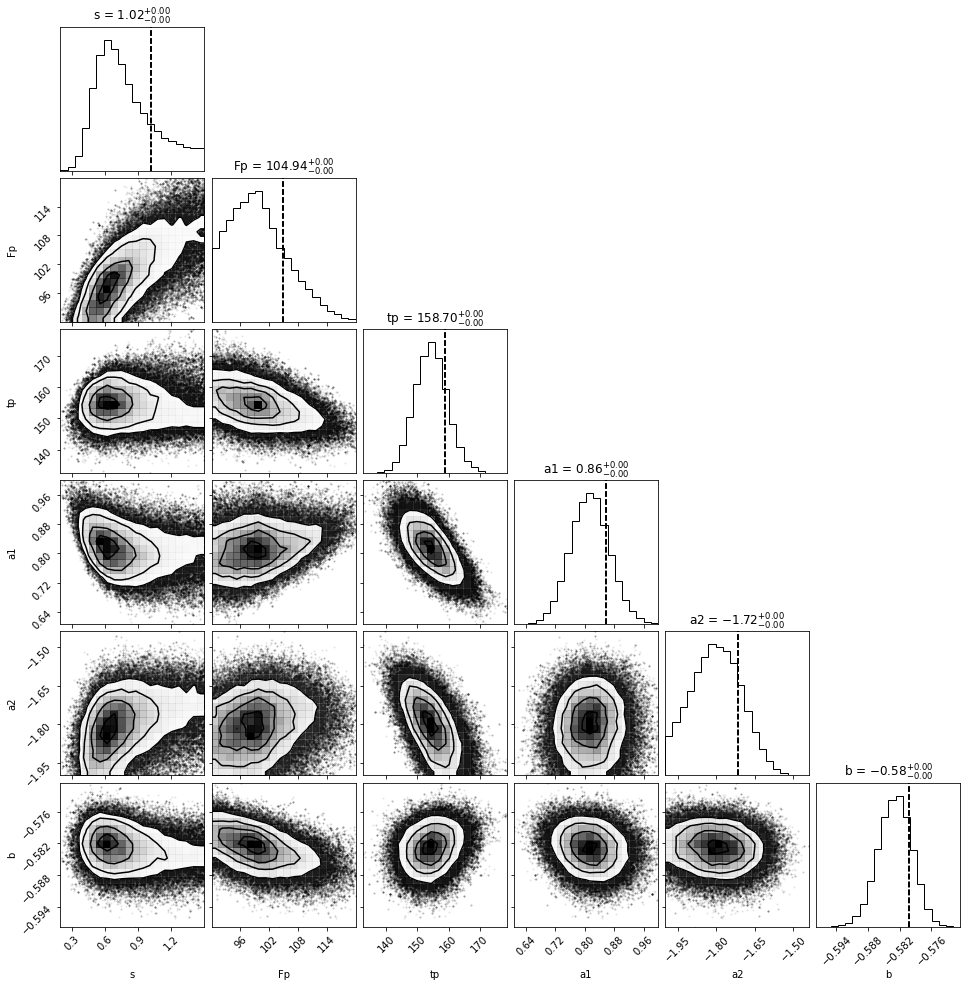

In [23]:
# List of labels for each parameter in the samples
labels = ['s', 'Fp', 'tp', 'a1', 'a2', 'b']

# Create a corner plot (also known as a triangle plot) using the 'corner' library
# Display parameter histograms on diagonal, scatter plots on off-diagonal, and titles for each subplot
# Use the provided parameter labels for the axes
# Plot data points instead of contours, and set quantiles for shading
fig = corner.corner(samplesCH, show_titles=True, labels=labels, plot_datapoints=True, quantiles=[0.8, 0.8, 0.8])


In the above code, the corner library is used to create a corner plot that displays histograms of parameter distributions along the diagonal and scatter plots on the off-diagonal. The show_titles parameter adds titles to each subplot, and the labels parameter assigns labels to the axes of the subplots, corresponding to the parameters in the MCMC samples. The plot_datapoints parameter specifies that data points should be plotted instead of contours, and the quantiles parameter determines the quantiles for shading regions in the plots. The resulting corner plot provides visual insights into the parameter correlations and distributions obtained from the MCMC analysis.




